## Organoid simulation (credit: Mason Hargrave, modif: Lucas Seninge)

This notebook is based on Mason's method to simulate organoids. It uses a stochastic model to determine which neurons will fire at t+1 based on neurons firing at t. See Mason's model description.

In [2]:
# Import modules
import numpy as np
np.random.seed(42)

Added inhibitory neurons to the total population: User can pick a proportion of inhibitory neurons which will be randomly picked in the neuron vector.

In the case of inhibitory neurons, neuron  $j$ firing at time  $t$ will cause neuron  $i$ to NOT fire at time  $t+1$. So we take the inverse of this probability so that in the product of $(1-p_{i,j})$ , inhibitory neurons firing will decrease the probability of neuron $i$ firing.

This simple model may need refinement as the biology of neuron inhibition is slightly different.

Also, we added a refractory period: if a neuron was firing at $t$, it won't be able to fire at $t+1$, no matter what the probability would have been.

## Model Initialization

In [21]:
# Simulation parameters
# Number of neurons
neurons = 1000

# Proportion of inhibitory neurons in the neuron population
prop_inhib = 0.2
# Generates a boolean array determining which neurons are inhibitory.
inhib_idx = np.random.choice(neurons, int(prop_inhib*neurons))
inhib = np.zeros(neurons, dtype=np.bool)
inhib[inhib_idx] = True

# Probability matrix - initialize randomly
probability_matrix = np.random.exponential(size=(neurons,neurons), scale=0.005)

# Neurons state - initialize randomly
initial_state = np.random.random(neurons) < 0.1
# Number of iterations - discret time steps (change to actual time?)
time = 1100

probability_matrix = probability_matrix/5 #Hacky scaling thing to stop LITERAL epiliepsy

mu = lambda stim_region: 125 * stim_region + 62.5
sigma = 12.5
def threshold(timestep, stim_region):
    return 1e-3 + 1e-1 * np.exp(-((np.arange(neurons) - mu(stim_region)) / sigma)**2) * (timestep < 600)

## Optimized version of next_state

In [22]:
def next_state(neurons, probability_matrix, previous_state, timestep, stim_region):
    """
    Get new state t+1 of active/inactive neurons by using probabilities of firing.
    
    Args:
        neurons (int): number of neurons to be simulated.
        probability_matrix (np.array): probability of neuron j firing at t causing neuron i to fire at t+1.
        previous_state (np.array): vector of neuron states at t .
        
    Returns:
        next_state (np.array): vector of neuron states at t+1.
    """
    # Probability that cell j will NOT affect cell i.
    # Restrict attention to cells that are firing.
    anti_probability_matrix = 1 - probability_matrix[:,previous_state]
    # Take product over the two cell types separately.
    # Use indexing instead of masked arrays because faster.
    inh_prod = np.prod(anti_probability_matrix[:,inhib[previous_state]], axis=1)
    exc_prod = np.prod(anti_probability_matrix[:,~inhib[previous_state]], axis=1)
    expectation_values = (1 - exc_prod) * inh_prod
    
    expectation_values[np.random.random(neurons) < threshold(timestep, stim_region)] = 1
    
    return (np.random.random(neurons) < expectation_values) & (previous_state==0)

In [23]:
%%time
states= np.zeros((time+1, neurons), dtype=np.bool)
states[0,:] = initial_state
for t in range(time):
    states[t+1,:] = next_state(neurons, probability_matrix, states[t,:], t, 1)

CPU times: user 415 ms, sys: 4.06 ms, total: 419 ms
Wall time: 251 ms


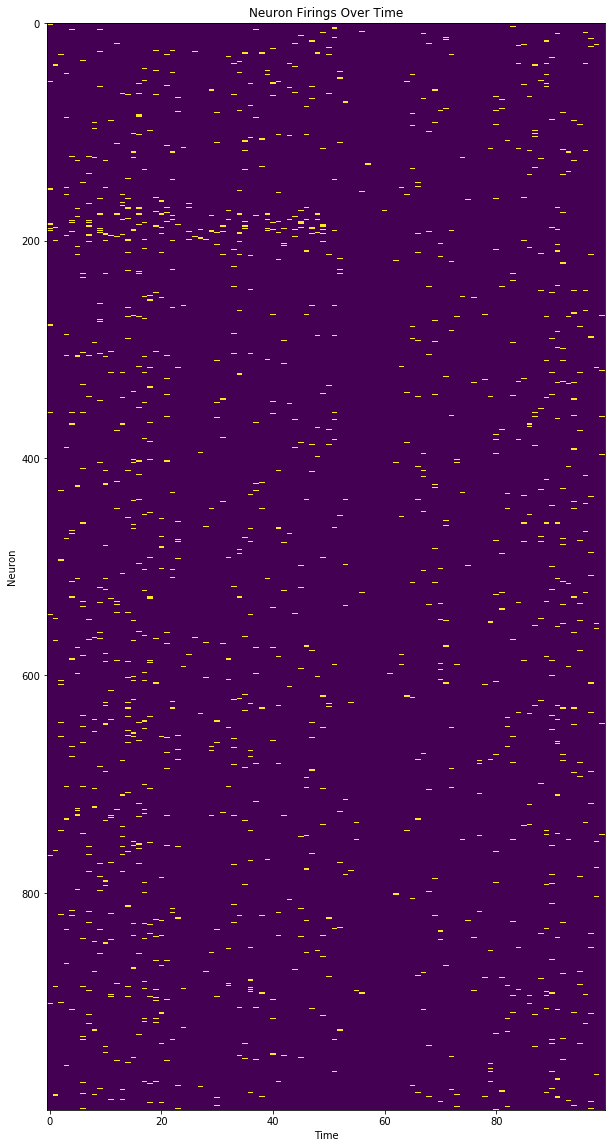

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,20))
plt.imshow(states.T[:,550:650], aspect='auto')
plt.xlabel("Time")
plt.ylabel("Neuron")
plt.title("Neuron Firings Over Time")
plt.savefig('my-version.png')

In [35]:
t_stop = 1000
t_snap = 1100

Npoints_train = 8
Npoints_test = 2
dataset_train = 'train.tfrecord'
dataset_test = 'test.tfrecord'

In [37]:
import tensorflow as tf

# This just draws a loop progress bar. If you don't want it,
# replace the import with the following:
# tqdm = lambda: None; tqdm.tqdm = lambda x: x
import tqdm

def write_data(dataset, Npoints):
    with tf.python_io.TFRecordWriter(dataset) as writer:
        for i in tqdm.tqdm(range(Npoints)):
            
            stim_region = np.random.randint(8)
            
            # create a (100,1000) array 'states' containing timeseries
            states = np.zeros((t_stop, neurons), dtype=np.bool)
            states[0,:] = initial_state
            for t in range(1, t_snap):
                states[t,:] = next_state(neurons, probability_matrix, states[t-1,:], t, stim_region)

            bits = bytes(np.packbits(states[t_stop:,:]))

            writer.write(tf.train.Example(features=tf.train.Features(feature = {
                'example': tf.train.Feature(bytes_list=tf.train.BytesList(value=[bits])),
                'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[int(pattern)]))
            })).SerializeToString())
            
write_data(dataset_train, Npoints_train)
write_data(dataset_test, Npoints_test)

ModuleNotFoundError: No module named 'tensorflow'